In [55]:
strategy_name = '培宏量化1号'

In [56]:
#%load_ext line_profiler
import sys
sys.path.append("C:\Program Files\Tinysoft\Analyse.NET")
sys.path.append(r"C:\Users\xudong\Documents\github\coresearch\funcs")
import importlib
import rschLib
import pymongo
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import datetime
import copy
import pandas as pd
from operator import itemgetter
import TSLPy3 as tsl
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import talib
import matplotlib.dates as mdates
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False
default_dpi = plt.rcParamsDefault['figure.dpi']
plt.rcParams['figure.dpi'] = default_dpi*1

np.set_printoptions(formatter={'float_kind': "{:.6f}".format})
client = pymongo.MongoClient('localhost', 27017)
db = client.quanLiang
dbt = client.tinySoftData

with open(r"d:\pkl\dailyBarMtx.pkl", 'rb+') as f:
    z = pickle.load(f)
dtes = z['dtes']
dtes = np.array(dtes).astype(np.int)
tkrs = list(z['tkrs'])
open_mtx = z['open_mtx']
high_mtx = z['high_mtx']
low_mtx = z['low_mtx']
close_mtx = z['close_mtx']

k = close_mtx==0
close_mtx = rschLib.zero2pre(close_mtx)
open_mtx[k]=close_mtx[k]
high_mtx[k]=close_mtx[k]
low_mtx[k]=close_mtx[k]

name = z['name']
belong = z['belong']
shenwan1 = z['shenwan1']
shenwan2 = z['shenwan2']
shenwan3 = z['shenwan3']
vol_mtx = z['vol_mtx']
amount_mtx = z['amount_mtx']


In [57]:
maxD = 4

In [58]:
dd = list(dbt.minuteBarStock.find({'ticker':'SH601988', 'dateAsInt':{'$gte':int(20200106), '$lte':int(20200109)}}, {'dateTime':1}))
timeAsFloat = []
for x in dd:
    l  = str(x['dateTime']+datetime.timedelta(hours=8))
    dl = float(l[0:4]+l[5:7]+l[8:10]+'.'+l[11:13]+l[14:16]+l[17:19])
    timeAsFloat.append(dl)
timeAsFloat=np.round(np.array(sorted(list(set([x - int(x) for x in timeAsFloat])))), 6)
timeLabels = []
dayOff = []
for i in range(maxD):
    for x in timeAsFloat:
        s = str(int(x*1e4))
        if len(s)<4:
            s='0'+s
        timeLabels.append('第'+str(i+1)+'天'+s[:2]+':'+s[2:4])
        dayOff.append(i)
timeAsFloat = list(timeAsFloat)*maxD
t = np.round(np.array(sorted(list(set([x - int(x) for x in timeAsFloat])))), 6)
maxM = t.shape[0] * maxD

In [59]:
trades = list(db.strategyBackTestTrades.find({'strategy_name':strategy_name}))
tradesUsed = []
Po = []
Ph = []
Pl = []
Pc = []
for (i,x) in enumerate(trades):
    #if (x['name'] in list(name)):
    p = list(name).index(x['name'])
    ticker = tkrs[p]
    d0 = x['dateIn']
    q = list(dtes).index(d0)
    j = np.min((q+maxD, dtes.shape[0]-1))
    d1 = dtes[j]
    dd = list(dbt.minuteBarStock.find({'ticker':ticker, 'dateAsInt':{'$gte':int(d0), '$lt':int(d1)}}, {'open':1, 'high':1, 'low':1,'close':1, 'dateTime':1}).sort([('dateTime',1)]))
    if dd==[]:
        continue
    tradesUsed.append(x)
    q = np.array([x['open'] for x in dd])
    print(i, '/', len(trades),len(q),dd[0]['dateTime'],dd[-1]['dateTime'])
    z = np.min((len(q),maxM))
    m = np.zeros(maxM)
    m[:z] = q[:z]
    m[z:] = m[z-1]
    Po.append(m)
    #q = np.array([x['high'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Ph.append(m)
    #q = np.array([x['low'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Pl.append(m)
    #q = np.array([x['close'] for x in dd])
    #z = np.min((len(q),maxM))
    #m = np.zeros(maxM)
    #m[:z]=q[:z]
    #m[z:]=m[z-1]
    #Pc.append(m)
Po = np.array(Po)
#Ph = np.array(Ph)
#Pl = np.array(Pl)
#Pc = np.array(Pc)

0 / 1068 960 2018-01-03 01:31:00 2018-01-08 07:00:00
1 / 1068 960 2018-01-04 01:31:00 2018-01-09 07:00:00
2 / 1068 960 2018-01-04 01:31:00 2018-01-09 07:00:00
3 / 1068 960 2018-01-05 01:31:00 2018-01-10 07:00:00
4 / 1068 960 2018-01-05 01:31:00 2018-01-10 07:00:00
5 / 1068 960 2018-01-08 01:31:00 2018-01-11 07:00:00
6 / 1068 960 2018-01-10 01:31:00 2018-01-15 07:00:00
7 / 1068 960 2018-01-11 01:31:00 2018-01-16 07:00:00
8 / 1068 960 2018-01-11 01:31:00 2018-01-16 07:00:00
9 / 1068 960 2018-01-12 01:31:00 2018-01-17 07:00:00
10 / 1068 960 2018-01-17 01:31:00 2018-01-22 07:00:00
11 / 1068 960 2018-01-17 01:31:00 2018-01-22 07:00:00
12 / 1068 960 2018-01-19 01:31:00 2018-01-24 07:00:00
13 / 1068 960 2018-01-22 01:31:00 2018-01-25 07:00:00
14 / 1068 960 2018-01-22 01:31:00 2018-01-25 07:00:00
15 / 1068 960 2018-01-23 01:31:00 2018-01-26 07:00:00
16 / 1068 960 2018-01-24 01:31:00 2018-01-29 07:00:00
17 / 1068 960 2018-01-24 01:31:00 2018-01-29 07:00:00
18 / 1068 960 2018-01-25 01:31:00 2018

153 / 1068 960 2018-05-29 01:31:00 2018-06-01 07:00:00
154 / 1068 960 2018-05-31 01:31:00 2018-06-05 07:00:00
155 / 1068 960 2018-06-04 01:31:00 2018-06-07 07:00:00
156 / 1068 960 2018-06-05 01:31:00 2018-06-08 07:00:00
157 / 1068 960 2018-06-06 01:31:00 2018-06-11 07:00:00
158 / 1068 960 2018-06-06 01:31:00 2018-06-11 07:00:00
159 / 1068 960 2018-06-06 01:31:00 2018-06-11 07:00:00
160 / 1068 960 2018-06-06 01:31:00 2018-06-11 07:00:00
161 / 1068 960 2018-06-06 01:31:00 2018-06-11 07:00:00
162 / 1068 960 2018-06-06 01:31:00 2018-06-11 07:00:00
163 / 1068 960 2018-06-06 01:31:00 2018-06-11 07:00:00
164 / 1068 960 2018-06-07 01:31:00 2018-06-12 07:00:00
165 / 1068 960 2018-06-07 01:31:00 2018-06-12 07:00:00
166 / 1068 960 2018-06-07 01:31:00 2018-06-12 07:00:00
167 / 1068 960 2018-06-13 01:31:00 2018-06-19 07:00:00
168 / 1068 960 2018-06-13 01:31:00 2018-06-19 07:00:00
169 / 1068 960 2018-06-21 01:31:00 2018-06-26 07:00:00
170 / 1068 960 2018-06-21 01:31:00 2018-06-26 07:00:00
171 / 1068

302 / 1068 960 2018-11-01 01:31:00 2018-11-06 07:00:00
303 / 1068 960 2018-11-01 01:31:00 2018-11-06 07:00:00
304 / 1068 960 2018-11-01 01:31:00 2018-11-06 07:00:00
305 / 1068 960 2018-11-01 01:31:00 2018-11-06 07:00:00
306 / 1068 960 2018-11-01 01:31:00 2018-11-06 07:00:00
307 / 1068 960 2018-11-02 01:31:00 2018-11-07 07:00:00
308 / 1068 960 2018-11-02 01:31:00 2018-11-07 07:00:00
309 / 1068 960 2018-11-05 01:31:00 2018-11-08 07:00:00
310 / 1068 960 2018-11-05 01:31:00 2018-11-08 07:00:00
311 / 1068 960 2018-11-06 01:31:00 2018-11-09 07:00:00
312 / 1068 960 2018-11-12 01:31:00 2018-11-15 07:00:00
313 / 1068 960 2018-11-13 01:31:00 2018-11-16 07:00:00
314 / 1068 960 2018-11-13 01:31:00 2018-11-16 07:00:00
315 / 1068 960 2018-11-14 01:31:00 2018-11-19 07:00:00
316 / 1068 960 2018-11-14 01:31:00 2018-11-19 07:00:00
317 / 1068 960 2018-11-15 01:31:00 2018-11-20 07:00:00
318 / 1068 960 2018-11-15 01:31:00 2018-11-20 07:00:00
319 / 1068 960 2018-11-15 01:31:00 2018-11-20 07:00:00
320 / 1068

455 / 1068 960 2019-03-06 01:31:00 2019-03-11 07:00:00
456 / 1068 960 2019-03-06 01:31:00 2019-03-11 07:00:00
457 / 1068 960 2019-03-06 01:31:00 2019-03-11 07:00:00
458 / 1068 960 2019-03-07 01:31:00 2019-03-12 07:00:00
459 / 1068 960 2019-03-07 01:31:00 2019-03-12 07:00:00
460 / 1068 960 2019-03-07 01:31:00 2019-03-12 07:00:00
461 / 1068 960 2019-03-07 01:31:00 2019-03-12 07:00:00
462 / 1068 960 2019-03-12 01:31:00 2019-03-15 07:00:00
463 / 1068 960 2019-03-12 01:31:00 2019-03-15 07:00:00
464 / 1068 960 2019-03-12 01:31:00 2019-03-15 07:00:00
465 / 1068 960 2019-03-12 01:31:00 2019-03-15 07:00:00
466 / 1068 960 2019-03-13 01:31:00 2019-03-18 07:00:00
467 / 1068 960 2019-03-14 01:31:00 2019-03-19 07:00:00
468 / 1068 960 2019-03-15 01:31:00 2019-03-20 07:00:00
469 / 1068 960 2019-03-15 01:31:00 2019-03-20 07:00:00
470 / 1068 960 2019-03-15 01:31:00 2019-03-20 07:00:00
471 / 1068 960 2019-03-18 01:31:00 2019-03-21 07:00:00
472 / 1068 960 2019-03-19 01:31:00 2019-03-22 07:00:00
473 / 1068

607 / 1068 960 2019-07-24 01:31:00 2019-07-29 07:00:00
608 / 1068 960 2019-07-24 01:31:00 2019-07-29 07:00:00
609 / 1068 960 2019-07-25 01:31:00 2019-07-30 07:00:00
610 / 1068 960 2019-07-26 01:31:00 2019-07-31 07:00:00
611 / 1068 960 2019-07-30 01:31:00 2019-08-02 07:00:00
612 / 1068 960 2019-07-30 01:31:00 2019-08-02 07:00:00
613 / 1068 960 2019-08-02 01:31:00 2019-08-07 07:00:00
614 / 1068 960 2019-08-02 01:31:00 2019-08-07 07:00:00
615 / 1068 960 2019-08-02 01:31:00 2019-08-07 07:00:00
616 / 1068 960 2019-08-02 01:31:00 2019-08-07 07:00:00
617 / 1068 960 2019-08-02 01:31:00 2019-08-07 07:00:00
618 / 1068 960 2019-08-02 01:31:00 2019-08-07 07:00:00
619 / 1068 960 2019-08-07 01:31:00 2019-08-12 07:00:00
620 / 1068 960 2019-08-07 01:31:00 2019-08-12 07:00:00
621 / 1068 960 2019-08-09 01:31:00 2019-08-14 07:00:00
622 / 1068 960 2019-08-09 01:31:00 2019-08-14 07:00:00
623 / 1068 960 2019-08-13 01:31:00 2019-08-16 07:00:00
624 / 1068 960 2019-08-13 01:31:00 2019-08-16 07:00:00
625 / 1068

762 / 1068 960 2020-01-07 01:31:00 2020-01-10 07:00:00
763 / 1068 960 2020-01-07 01:31:00 2020-01-10 07:00:00
764 / 1068 960 2020-01-07 01:31:00 2020-01-10 07:00:00
765 / 1068 960 2020-01-09 01:31:00 2020-01-14 07:00:00
766 / 1068 960 2020-01-09 01:31:00 2020-01-14 07:00:00
767 / 1068 960 2020-01-09 01:31:00 2020-01-14 07:00:00
768 / 1068 960 2020-01-14 01:31:00 2020-01-17 07:00:00
769 / 1068 960 2020-01-20 01:31:00 2020-01-23 07:00:00
770 / 1068 960 2020-01-21 01:31:00 2020-02-03 07:00:00
771 / 1068 960 2020-01-21 01:31:00 2020-02-03 07:00:00
772 / 1068 960 2020-02-04 01:31:00 2020-02-07 07:00:00
773 / 1068 960 2020-02-04 01:31:00 2020-02-07 07:00:00
774 / 1068 960 2020-02-04 01:31:00 2020-02-07 07:00:00
775 / 1068 960 2020-02-05 01:31:00 2020-02-10 07:00:00
776 / 1068 960 2020-02-05 01:31:00 2020-02-10 07:00:00
777 / 1068 960 2020-02-05 01:31:00 2020-02-10 07:00:00
778 / 1068 960 2020-02-05 01:31:00 2020-02-10 07:00:00
779 / 1068 960 2020-02-05 01:31:00 2020-02-10 07:00:00
780 / 1068

913 / 1068 960 2020-05-11 01:31:00 2020-05-14 07:00:00
914 / 1068 960 2020-05-11 01:31:00 2020-05-14 07:00:00
915 / 1068 960 2020-05-11 01:31:00 2020-05-14 07:00:00
916 / 1068 960 2020-05-14 01:31:00 2020-05-19 07:00:00
917 / 1068 960 2020-05-14 01:31:00 2020-05-19 07:00:00
918 / 1068 960 2020-05-18 01:31:00 2020-05-21 07:00:00
919 / 1068 960 2020-05-18 01:31:00 2020-05-21 07:00:00
920 / 1068 960 2020-05-18 01:31:00 2020-05-21 07:00:00
921 / 1068 960 2020-05-18 01:31:00 2020-05-21 07:00:00
922 / 1068 960 2020-05-19 01:31:00 2020-05-22 07:00:00
923 / 1068 960 2020-05-19 01:31:00 2020-05-22 07:00:00
924 / 1068 960 2020-05-19 01:31:00 2020-05-22 07:00:00
925 / 1068 960 2020-05-19 01:31:00 2020-05-22 07:00:00
926 / 1068 960 2020-05-20 01:31:00 2020-05-25 07:00:00
927 / 1068 960 2020-05-22 01:31:00 2020-05-27 07:00:00
928 / 1068 960 2020-05-26 01:31:00 2020-05-29 07:00:00
929 / 1068 960 2020-05-27 01:31:00 2020-06-01 07:00:00
930 / 1068 960 2020-05-28 01:31:00 2020-06-02 07:00:00
931 / 1068

In [60]:
#x = [str(x) for x in dateLabel]
#dateLabel
#dLabel = np.array([datetime.datetime.strptime(str(int(float(d)*1e4)), '%H%M').date() for d in x])

In [61]:
r=Po[:,1:]/Po[:,:-1] - 1
r=np.hstack((np.zeros((r.shape[0],1)),r))

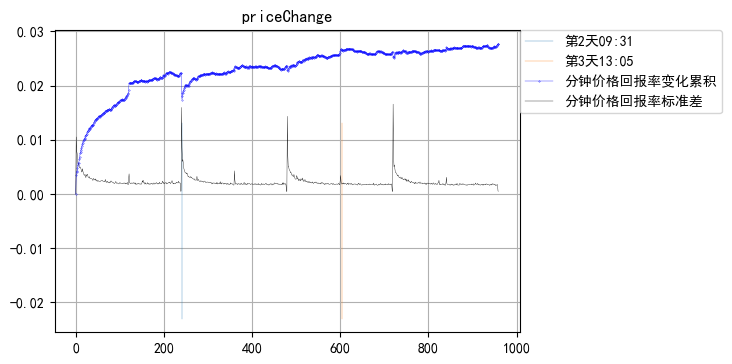

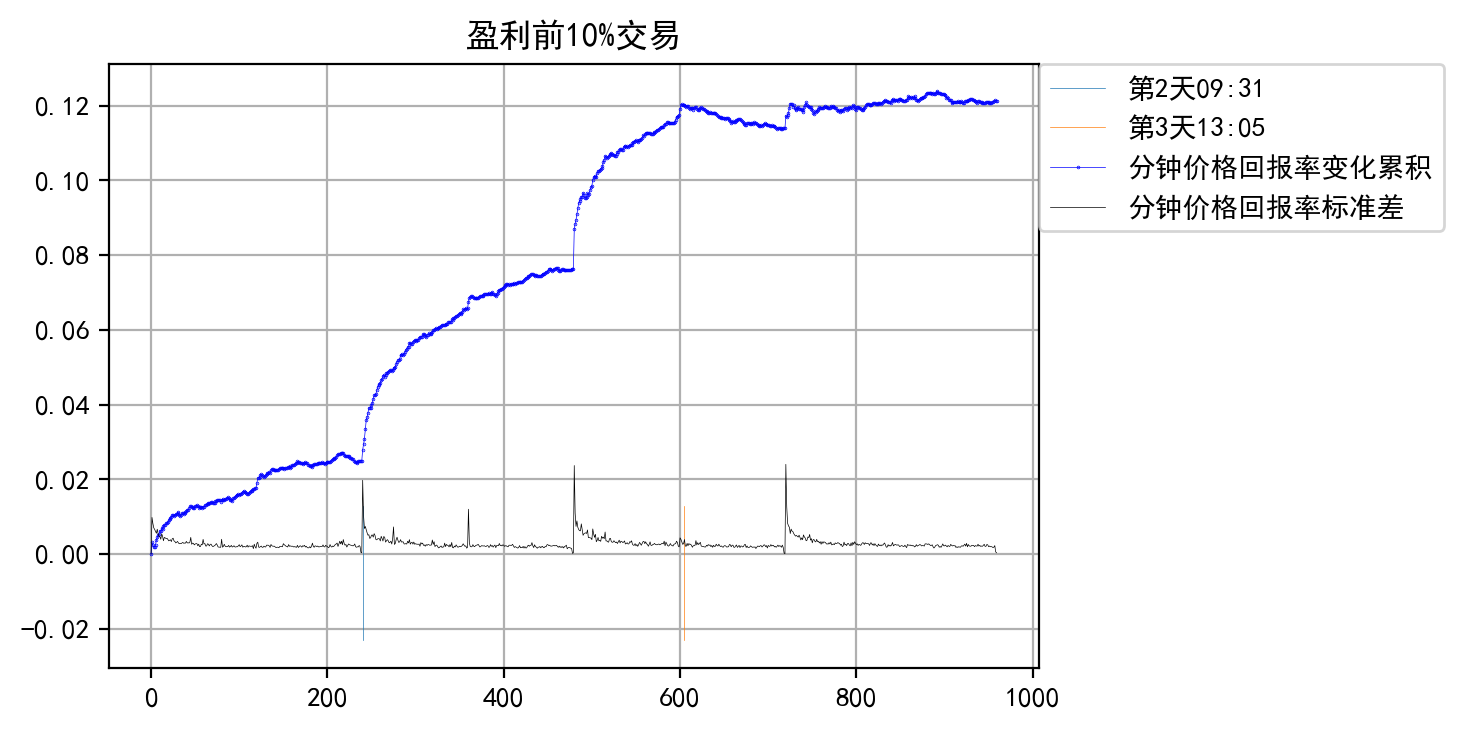

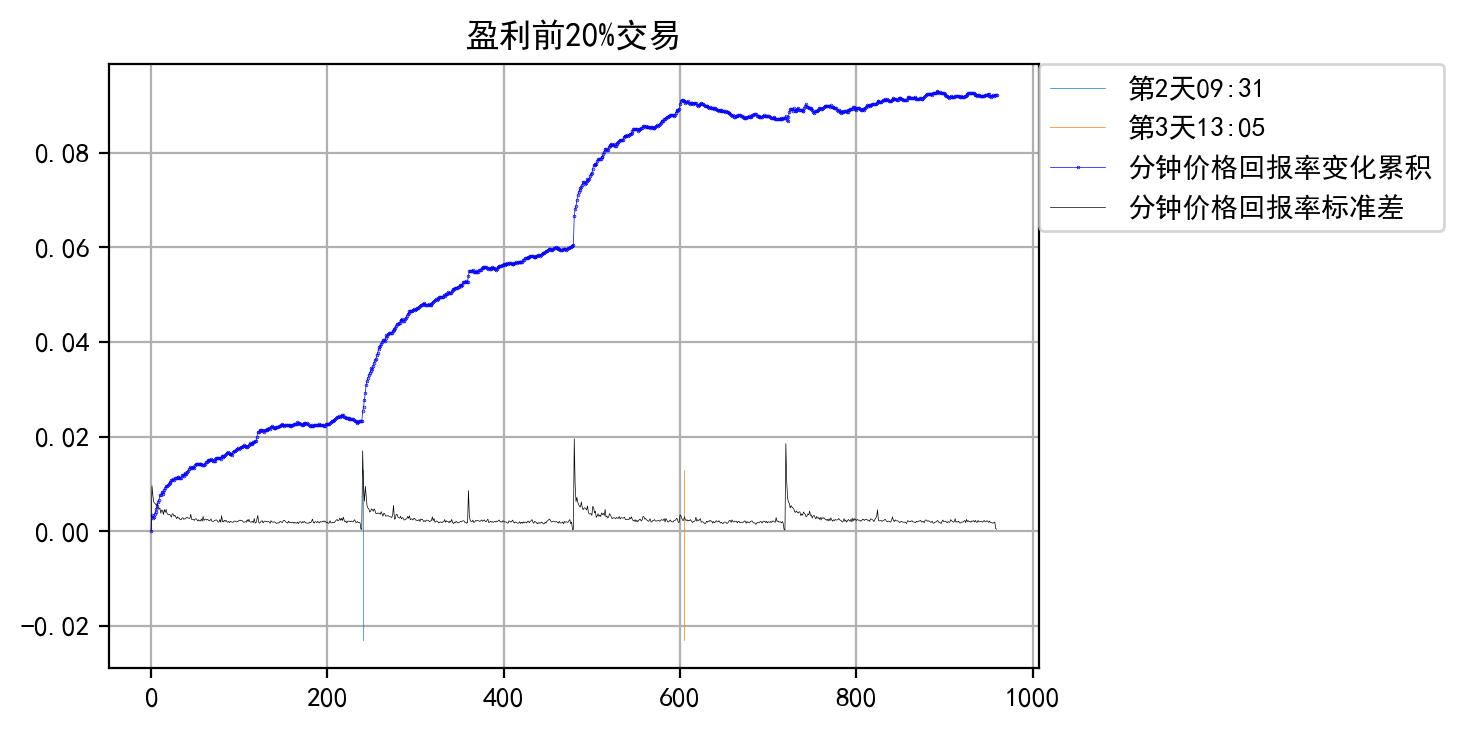

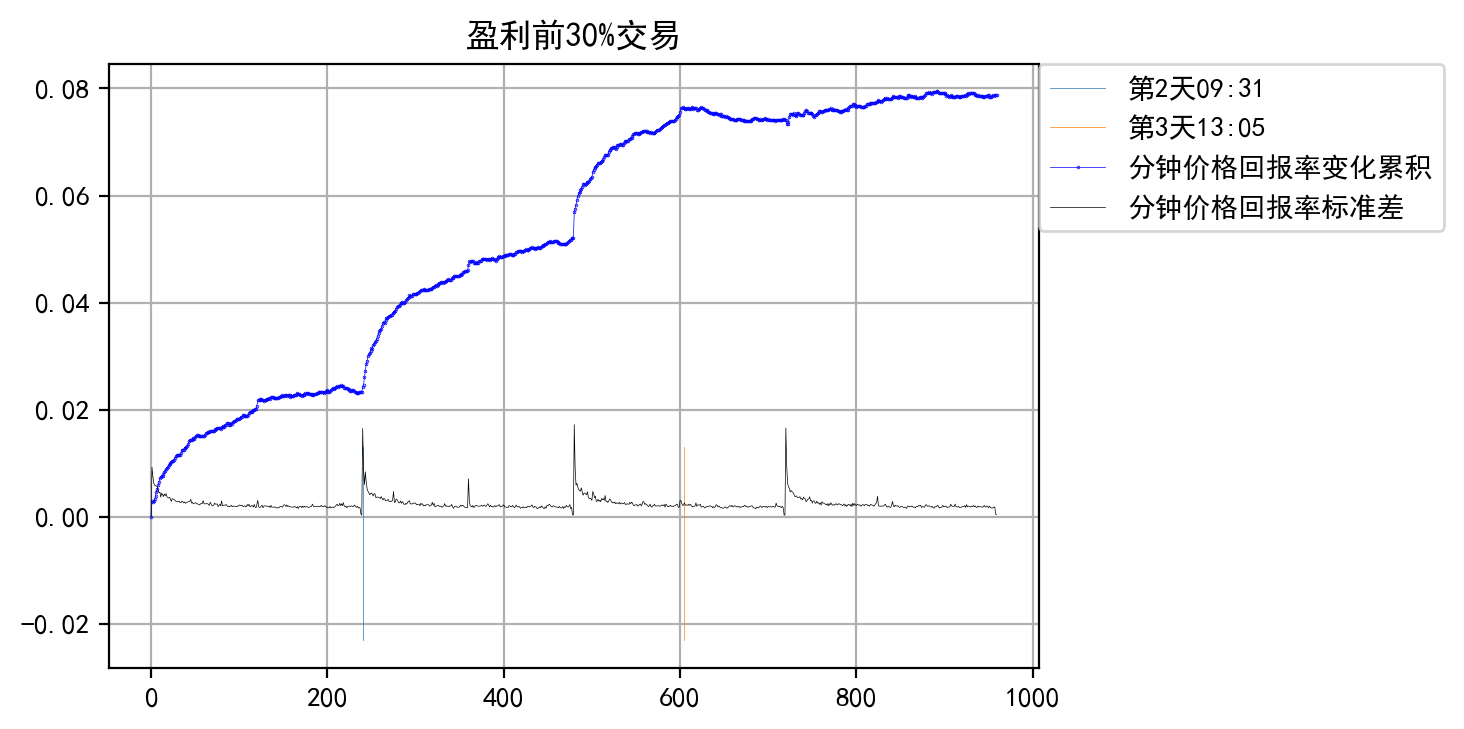

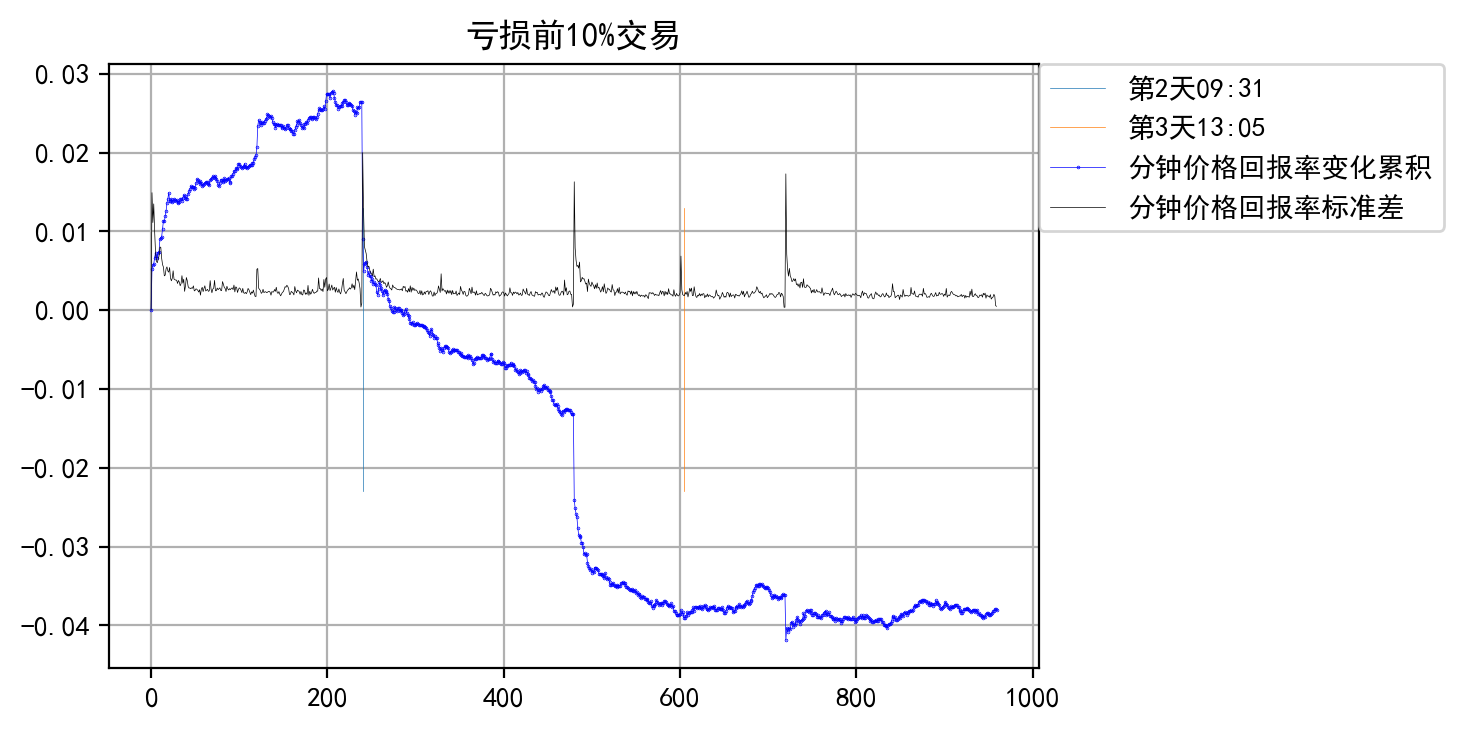

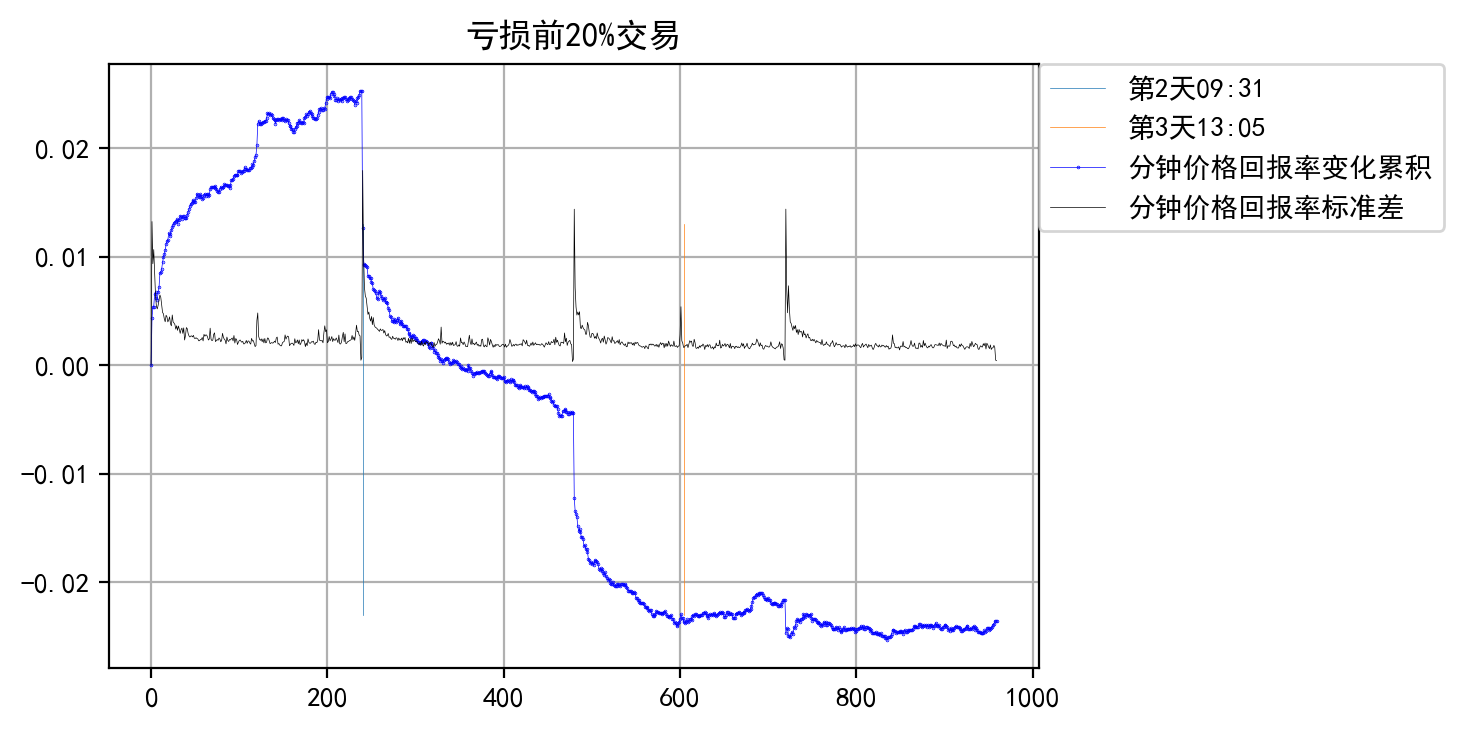

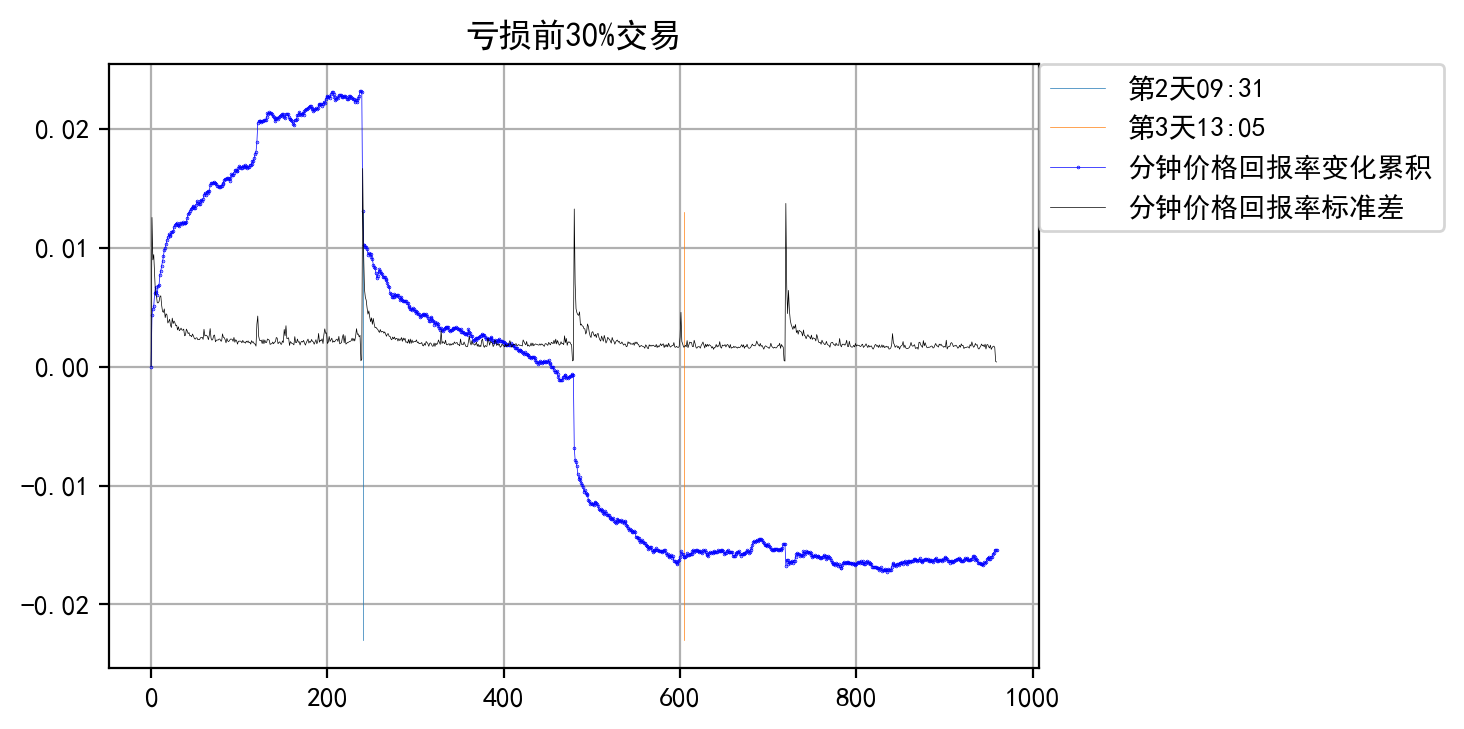

In [62]:
tradeArea=[240,604]
h = np.max(np.cumsum(r[:, :tradeArea[0]], axis=1), axis=1)
isZhangtingBeforeTradeArea = h>=0.05
p = np.sum(r[:, tradeArea[0]:tradeArea[1]], axis=1)
u = np.quantile(p,0.9)
u2 = np.quantile(p,0.8)
u3 = np.quantile(p,0.7)
l = np.quantile(p,0.1)
l2 = np.quantile(p,0.2)
l3 = np.quantile(p,0.3)
rGood = r[p>=u,:]
rGood2 = r[p>=u2,:]
rGood3 = r[p>=u3,:]
rBad = r[p<=l, :]
rBad2 = r[p<=l2, :]
rBad3 = r[p<=l3, :]
#for (i,x) in enumerate(tradesUsed):
#    if p[i]>u:
#        print('good trade:', x['name'], x['dateIn'],p[i],isZhangtingBeforeTradeArea[i])
#    if p[i]<l:
#        print('bad trade:', x['name'], x['dateIn'], p[i],isZhangtingBeforeTradeArea[i])
importlib.reload(rschLib)
rschLib.drawPriceChange(r, strategy_name, timeLabels=timeLabels, tp=tradeArea)
rschLib.drawPriceChange(rGood, strategy_name, timeLabels=timeLabels, title='盈利前10%交易', tp=tradeArea)
rschLib.drawPriceChange(rGood2, strategy_name, timeLabels=timeLabels, title='盈利前20%交易', tp=tradeArea)
rschLib.drawPriceChange(rGood3, strategy_name, timeLabels=timeLabels, title='盈利前30%交易', tp=tradeArea)
rschLib.drawPriceChange(rBad, strategy_name, timeLabels=timeLabels, title='亏损前10%交易', tp=tradeArea)
rschLib.drawPriceChange(rBad2, strategy_name, timeLabels=timeLabels, title='亏损前20%交易', tp=tradeArea)
rschLib.drawPriceChange(rBad3, strategy_name, timeLabels=timeLabels, title='亏损前30%交易', tp=tradeArea)

In [63]:
inTime = 240
otTime = 604

In [64]:
importlib.reload(rschLib)
[dtesPnl,pnl,numTrades]=rschLib.getPnl(dtes,tkrs, name, trades, inTime, otTime, dayOff, timeAsFloat, toDatabase='yes')


20180103 中远海控 20180104.0931 价 6.99 20180105.1305 价 7.19 利润 2.86 %
20180104 常熟银行 20180105.0931 价 7.98 20180108.1305 价 7.86 利润 -1.5 %
20180104 中国宝安 20180105.0931 价 7.65 20180108.1305 价 7.55 利润 -1.31 %
20180105 易见股份 20180108.0931 价 11.43 20180109.1305 价 14.0 利润 22.48 %
20180105 燕京啤酒 20180108.0931 价 7.2 20180109.1305 价 7.22 利润 0.28 %
20180108 温氏股份 20180109.0931 价 26.52 20180110.1305 价 26.58 利润 0.23 %
20180110 海油工程 20180111.0931 价 6.74 20180112.1305 价 6.7 利润 -0.59 %
20180111 广电运通 20180112.0931 价 8.54 20180115.1305 价 7.95 利润 -6.91 %
20180111 万达信息 20180112.0931 价 14.01 20180115.1305 价 13.33 利润 -4.85 %
20180112 万通发展 20180115.0931 价 5.11 20180116.1305 价 4.72 利润 -7.63 %
20180117 东方证券 20180118.0931 价 14.38 20180119.1305 价 14.56 利润 1.25 %
20180117 上海钢联 20180118.0931 价 44.87 20180119.1305 价 47.55 利润 5.97 %
20180119 华谊集团 20180122.0931 价 9.06 20180123.1305 价 9.25 利润 2.1 %
20180122 华宇软件 20180123.0931 价 15.58 20180124.1305 价 16.33 利润 4.81 %
20180122 易华录 20180123.0931 价 26.55 20180124.1305 价 27.39 利润 3.

20180504 普洛药业 20180507.0931 价 6.9 20180508.1305 价 7.2 利润 4.35 %
20180504 三友化工 20180507.0931 价 8.9 20180508.1305 价 9.44 利润 6.07 %
20180508 杉杉股份 20180509.0931 价 20.49 20180510.1305 价 20.99 利润 2.44 %
20180508 航天电子 20180509.0931 价 8.33 20180510.1305 价 8.16 利润 -2.04 %
20180508 润和软件 20180509.0931 价 13.31 20180510.1305 价 12.93 利润 -2.85 %
20180510 四川路桥 20180511.0931 价 3.82 20180514.1305 价 3.8 利润 -0.52 %
20180510 奇正藏药 20180511.0931 价 36.3 20180514.1305 价 35.58 利润 -1.98 %
20180511 九洲药业 20180514.0931 价 11.0 20180515.1305 价 10.49 利润 -4.64 %
20180511 维信诺 20180514.0931 价 14.65 20180515.1305 价 14.81 利润 1.09 %
20180515 上海电气 20180516.0931 价 6.13 20180517.1305 价 6.11 利润 -0.33 %
20180516 旗滨集团 20180517.0931 价 5.5 20180518.1305 价 5.63 利润 2.36 %
20180516 华谊集团 20180517.0931 价 11.05 20180518.1305 价 12.28 利润 11.13 %
20180516 天坛生物 20180517.0931 价 30.05 20180518.1305 价 29.24 利润 -2.7 %
20180517 常山北明 20180518.0931 价 8.75 20180521.1305 价 9.04 利润 3.31 %
20180521 中远海发 20180522.0931 价 3.09 20180523.1305 价 3.05 利润 -1.2

20180907 中国神华 20180910.0931 价 18.7 20180911.1305 价 18.25 利润 -2.41 %
20180911 许继电气 20180912.0931 价 8.35 20180913.1305 价 8.69 利润 4.07 %
20180913 中兴通讯 20180914.0931 价 18.54 20180917.1305 价 18.48 利润 -0.32 %
20180913 中际旭创 20180914.0931 价 45.18 20180917.1305 价 44.06 利润 -2.48 %
20180913 云南铜业 20180914.0931 价 9.1 20180917.1305 价 8.89 利润 -2.31 %
20180913 中国太保 20180914.0931 价 32.2 20180917.1305 价 32.07 利润 -0.4 %
20180914 长安汽车 20180917.0931 价 6.71 20180918.1305 价 6.66 利润 -0.75 %
20180914 比亚迪 20180917.0931 价 44.0 20180918.1305 价 44.4 利润 0.91 %
20180919 申通快递 20180920.0931 价 17.29 20180921.1305 价 18.35 利润 6.13 %
20180919 攀钢钒钛 20180920.0931 价 3.6 20180921.1305 价 3.66 利润 1.67 %
20180919 越秀金控 20180920.0931 价 7.06 20180921.1305 价 7.06 利润 0.0 %
20180919 南极电商 20180920.0931 价 7.43 20180921.1305 价 7.28 利润 -2.02 %
20180919 老百姓   20180920.0931 价 57.06 20180921.1305 价 58.18 利润 1.96 %
20180919 宋城演艺 20180920.0931 价 20.8 20180921.1305 价 21.41 利润 2.93 %
20180920 五矿稀土 20180921.0931 价 9.53 20180925.1305 价 9.63 利润 1.0

20190211 九洲药业 20190212.0931 价 6.88 20190213.1305 价 7.1 利润 3.2 %
20190211 生物股份 20190212.0931 价 15.96 20190213.1305 价 16.0 利润 0.25 %
20190211 海翔药业 20190212.0931 价 4.72 20190213.1305 价 4.9 利润 3.81 %
20190211 一汽解放 20190212.0931 价 7.15 20190213.1305 价 7.28 利润 1.82 %
20190211 上海钢联 20190212.0931 价 55.0 20190213.1305 价 58.79 利润 6.89 %
20190212 绿盟科技 20190213.0931 价 10.09 20190214.1305 价 10.43 利润 3.37 %
20190212 蓝思科技 20190213.0931 价 7.05 20190214.1305 价 7.2 利润 2.13 %
20190212 工业富联 20190213.0931 价 12.6 20190214.1305 价 13.89 利润 10.24 %
20190212 利亚德 20190213.0931 价 7.08 20190214.1305 价 7.18 利润 1.41 %
20190212 广汇能源 20190213.0931 价 3.89 20190214.1305 价 4.02 利润 3.34 %
20190212 东山精密 20190213.0931 价 13.0 20190214.1305 价 12.96 利润 -0.31 %
20190212 安科生物 20190213.0931 价 13.62 20190214.1305 价 14.0 利润 2.79 %
20190213 龙蟒佰利 20190214.0931 价 13.5 20190215.1305 价 13.71 利润 1.56 %
20190213 万润股份 20190214.0931 价 12.05 20190215.1305 价 11.56 利润 -4.07 %
20190213 长信科技 20190214.0931 价 5.33 20190215.1305 价 5.34 利润 0.19 %
20

20190529 包钢股份 20190530.0931 价 1.73 20190531.1305 价 1.78 利润 2.89 %
20190529 北方稀土 20190530.0931 价 13.26 20190531.1305 价 13.56 利润 2.26 %
20190603 紫金矿业 20190604.0931 价 3.39 20190605.1305 价 3.34 利润 -1.47 %
20190603 中金黄金 20190604.0931 价 8.49 20190605.1305 价 8.55 利润 0.71 %
20190603 长城汽车 20190604.0931 价 8.56 20190605.1305 价 8.83 利润 3.15 %
20190611 旗滨集团 20190612.0931 价 3.75 20190613.1305 价 3.69 利润 -1.6 %
20190611 中国交建 20190612.0931 价 11.43 20190613.1305 价 11.22 利润 -1.84 %
20190611 中国中铁 20190612.0931 价 6.62 20190613.1305 价 6.57 利润 -0.76 %
20190611 中国铁建 20190612.0931 价 10.14 20190613.1305 价 9.97 利润 -1.68 %
20190611 中国电建 20190612.0931 价 5.14 20190613.1305 价 5.2 利润 1.17 %
20190611 中国中冶 20190612.0931 价 3.04 20190613.1305 价 3.02 利润 -0.66 %
20190611 中国建筑 20190612.0931 价 5.96 20190613.1305 价 5.9 利润 -1.01 %
20190611 中国中车 20190612.0931 价 8.18 20190613.1305 价 8.11 利润 -0.86 %
20190611 中铁工业 20190612.0931 价 10.47 20190613.1305 价 10.55 利润 0.76 %
20190614 中国重工 20190617.0931 价 5.24 20190618.1305 价 5.19 利润 -0.95

20190916 海油工程 20190917.0931 价 5.76 20190918.1305 价 5.47 利润 -5.03 %
20190916 上海石化 20190917.0931 价 4.54 20190918.1305 价 4.33 利润 -4.63 %
20190916 大族激光 20190917.0931 价 35.98 20190918.1305 价 35.65 利润 -0.92 %
20190919 东方时尚 20190920.0931 价 19.33 20190923.1305 价 20.24 利润 4.71 %
20190920 中铁工业 20190923.0931 价 10.85 20190924.1305 价 10.75 利润 -0.92 %
20190920 顾家家居 20190923.0931 价 36.88 20190924.1305 价 35.52 利润 -3.69 %
20190920 均胜电子 20190923.0931 价 16.88 20190924.1305 价 17.06 利润 1.07 %
20190925 吉祥航空 20190926.0931 价 14.36 20190927.1305 价 14.06 利润 -2.09 %
20190930 中集集团 20191008.0931 价 10.18 20191009.1305 价 9.95 利润 -2.26 %
20190930 中国石油 20191008.0931 价 6.19 20191009.1305 价 6.07 利润 -1.94 %
20191008 天邦股份 20191009.0931 价 12.38 20191010.1305 价 12.56 利润 1.45 %
20191010 许继电气 20191011.0931 价 9.95 20191014.1305 价 9.85 利润 -1.01 %
20191010 安迪苏   20191011.0931 价 10.98 20191014.1305 价 10.86 利润 -1.09 %
20191010 科大讯飞 20191011.0931 价 34.0 20191014.1305 价 34.06 利润 0.18 %
20191010 陕国投Ａ 20191011.0931 价 4.26 20191014.130

20200224 际华集团 20200225.0931 价 4.39 20200226.1305 价 4.31 利润 -1.82 %
20200224 东华能源 20200225.0931 价 10.14 20200226.1305 价 10.08 利润 -0.59 %
20200225 中信国安 20200226.0931 价 4.05 20200227.1305 价 3.84 利润 -5.19 %
20200302 渤海租赁 20200303.0931 价 3.46 20200304.1305 价 3.45 利润 -0.29 %
20200303 天邦股份 20200304.0931 价 11.37 20200305.1305 价 13.05 利润 14.78 %
20200303 传化智联 20200304.0931 价 6.79 20200305.1305 价 6.97 利润 2.65 %
20200304 闰土股份 20200305.0931 价 11.95 20200306.1305 价 11.75 利润 -1.67 %
20200304 龙净环保 20200305.0931 价 11.44 20200306.1305 价 11.4 利润 -0.35 %
20200305 中航资本 20200306.0931 价 4.59 20200309.1305 价 4.35 利润 -5.23 %
20200305 上海电气 20200306.0931 价 4.84 20200309.1305 价 4.95 利润 2.27 %
20200305 海峡股份 20200306.0931 价 14.2 20200309.1305 价 16.24 利润 14.37 %
20200305 市北高新 20200306.0931 价 8.59 20200309.1305 价 9.13 利润 6.29 %
20200305 易事特 20200306.0931 价 5.37 20200309.1305 价 5.96 利润 10.99 %
20200305 申万宏源 20200306.0931 价 4.94 20200309.1305 价 4.8 利润 -2.83 %
20200306 合盛硅业 20200309.0931 价 29.14 20200310.1305 价 29.93 利

20200608 中海油服 20200609.0931 价 14.14 20200610.1305 价 13.79 利润 -2.48 %
20200615 君正集团 20200616.0931 价 2.54 20200617.1305 价 2.56 利润 0.79 %
20200617 寒锐钴业 20200618.0931 价 62.71 20200619.1305 价 62.72 利润 0.02 %
20200617 中航沈飞 20200618.0931 价 33.01 20200619.1305 价 31.92 利润 -3.3 %
20200617 中直股份 20200618.0931 价 41.12 20200619.1305 价 40.69 利润 -1.05 %
20200622 泰禾集团 20200623.0931 价 5.16 20200624.1305 价 5.31 利润 2.91 %
20200622 美年健康 20200623.0931 价 13.58 20200624.1305 价 13.54 利润 -0.29 %
20200622 格林美 20200623.0931 价 4.84 20200624.1305 价 4.93 利润 1.86 %
20200622 信立泰 20200623.0931 价 27.18 20200624.1305 价 27.03 利润 -0.55 %
20200629 中信银行 20200630.0931 价 5.21 20200701.1305 价 5.19 利润 -0.38 %
20200701 人民网   20200702.0931 价 20.65 20200703.1305 价 20.85 利润 0.97 %
20200701 新华网   20200702.0931 价 23.0 20200703.1305 价 23.63 利润 2.74 %
20200701 东软集团 20200702.0931 价 12.17 20200703.1305 价 12.39 利润 1.81 %
20200703 中泰化学 20200706.0931 价 5.15 20200707.1305 价 5.34 利润 3.69 %
20200703 三友化工 20200706.0931 价 5.17 20200707.1305 价 5.2

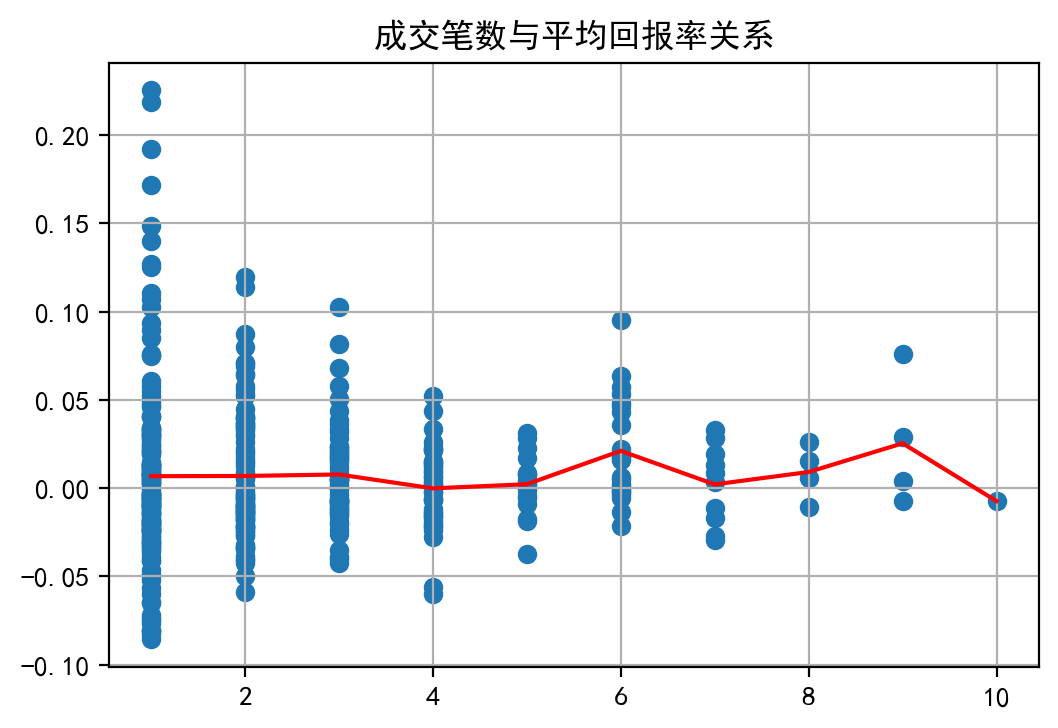

In [65]:
importlib.reload(rschLib)
rschLib.pnlVsNumtrades(pnl, numTrades)

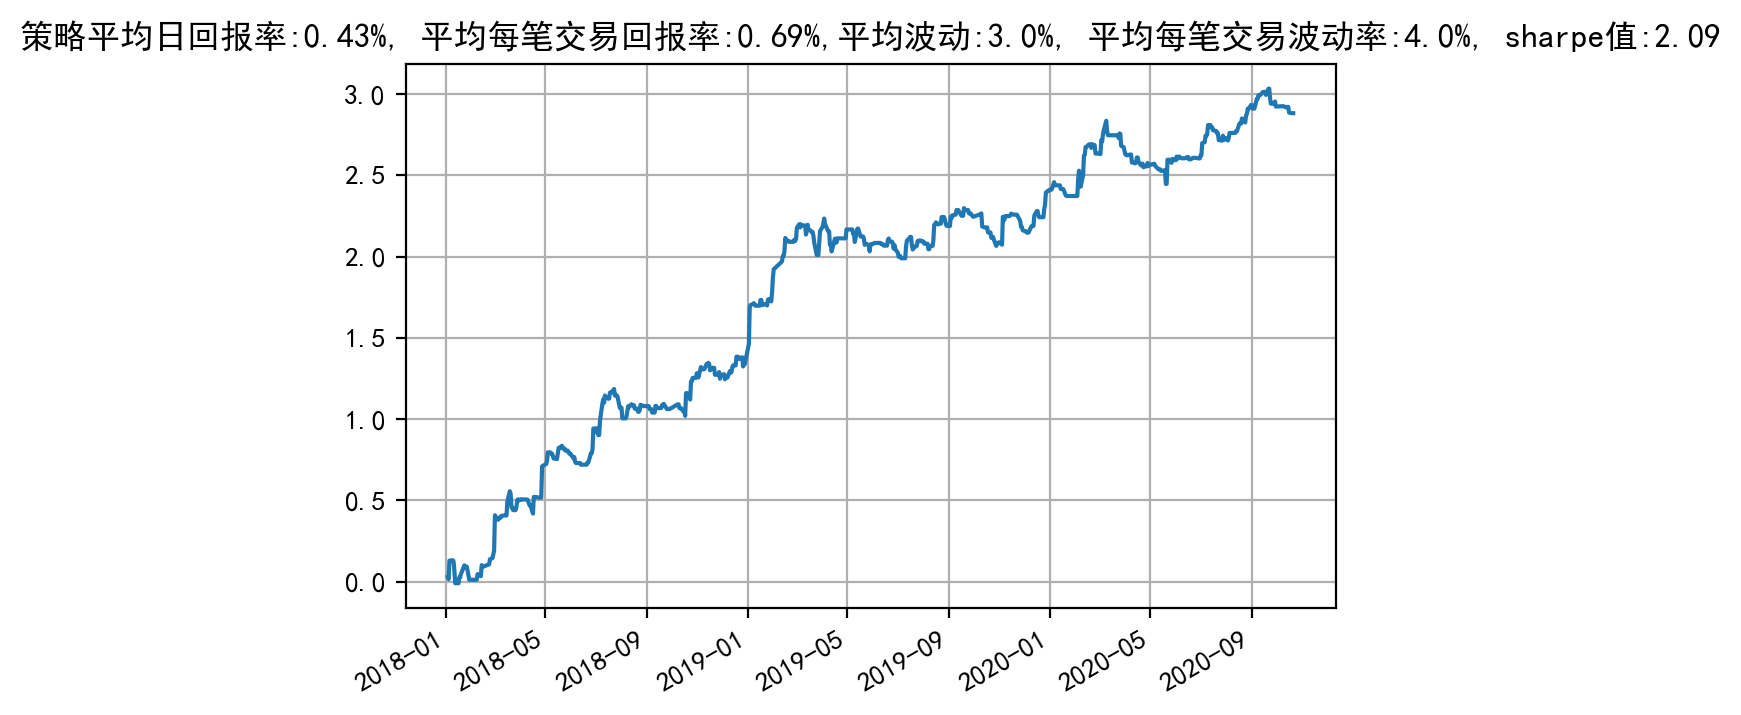

In [66]:
rschLib.drawPNL(dtesPnl, pnl, dtes, strategy_name, toDatabase='yes')

In [67]:
#%lprun -f getPnl getPnl()